In [170]:
import numpy as np
import pandas as pd

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV


In [172]:
data = pd.read_csv("C:/Users/jppec/Downloads/house-prices-advanced-regression-techniques (1)/train.csv")

In [173]:
# 1. Análise exploratória de dados
print(data.head())
print(data.info())
print(data.describe())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

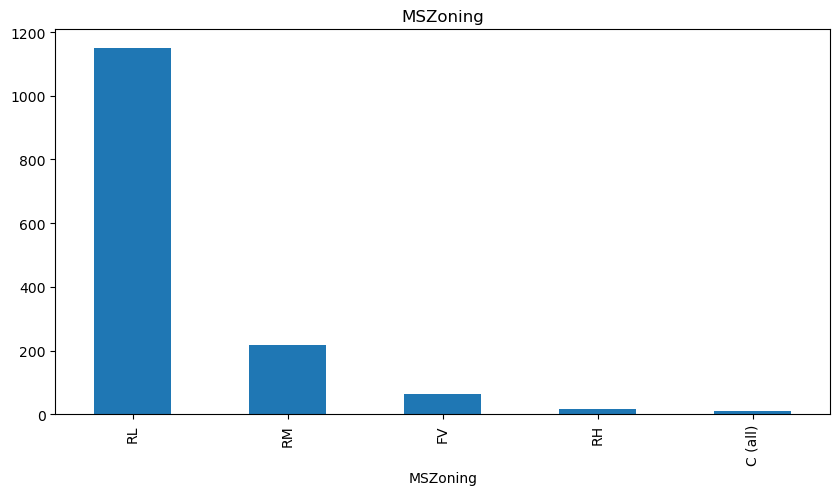

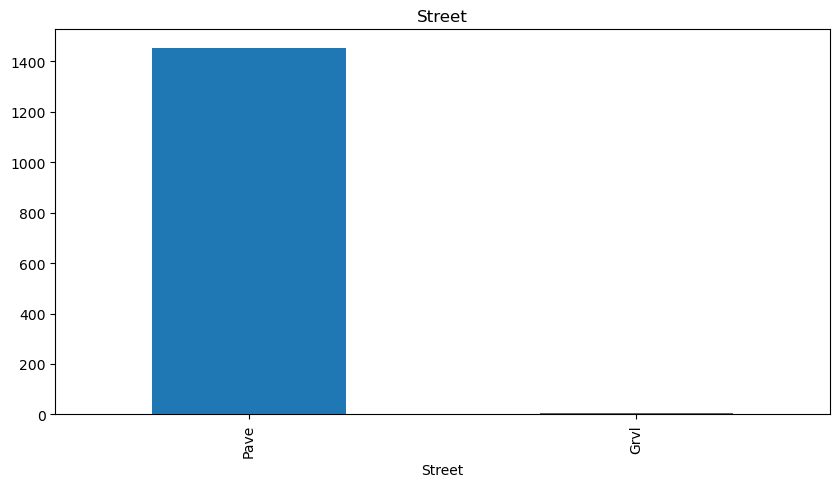

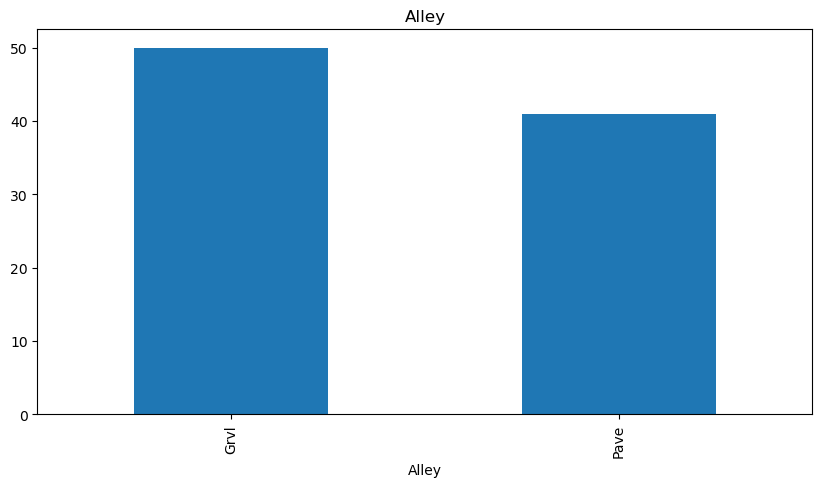

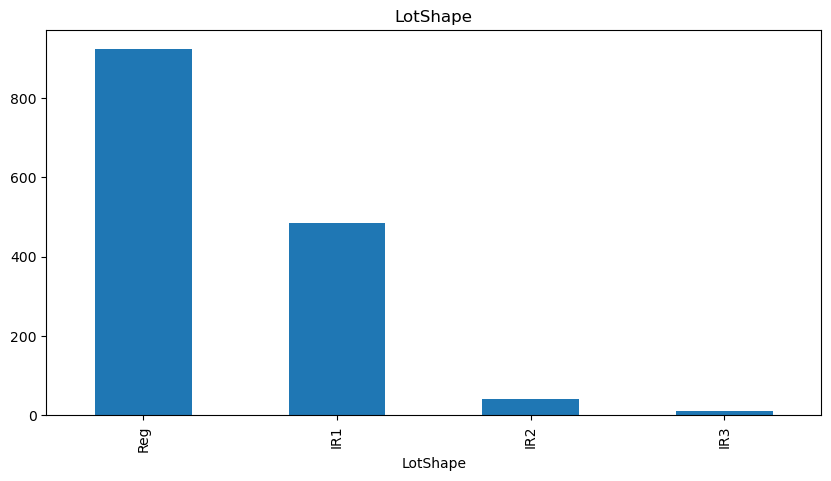

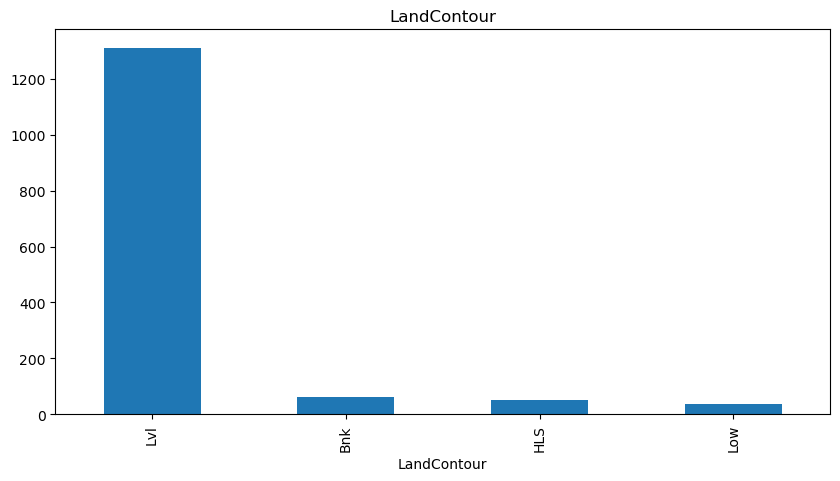

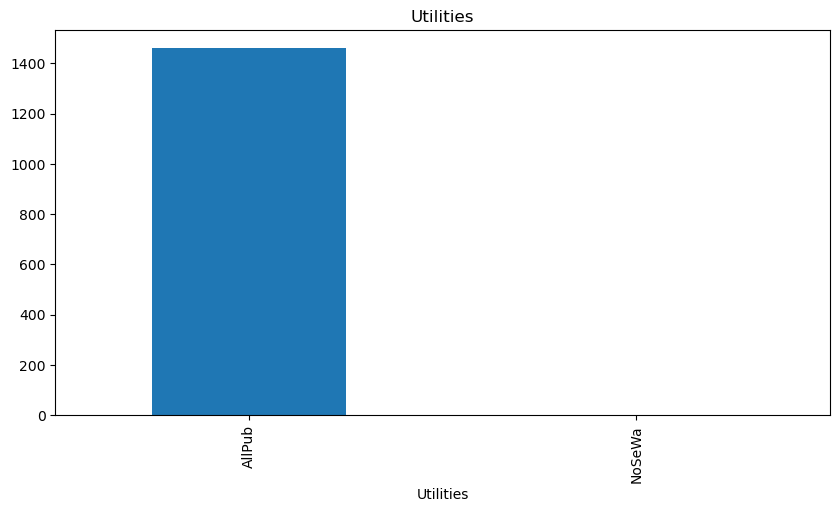

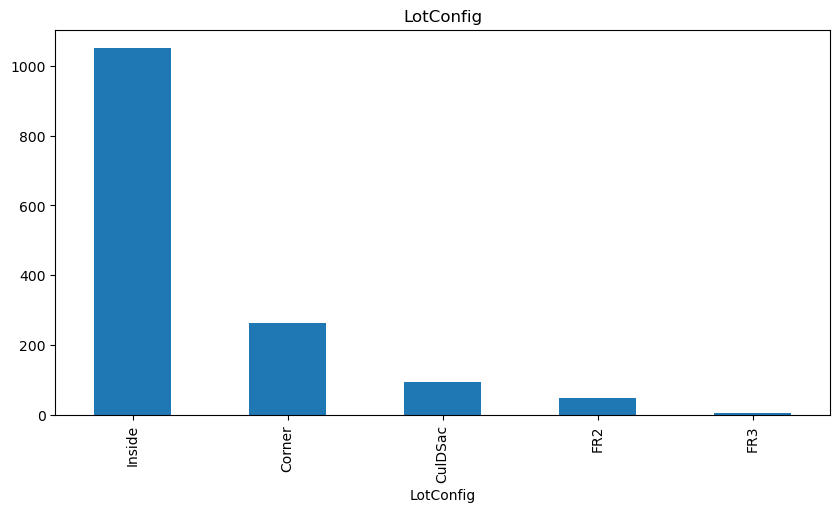

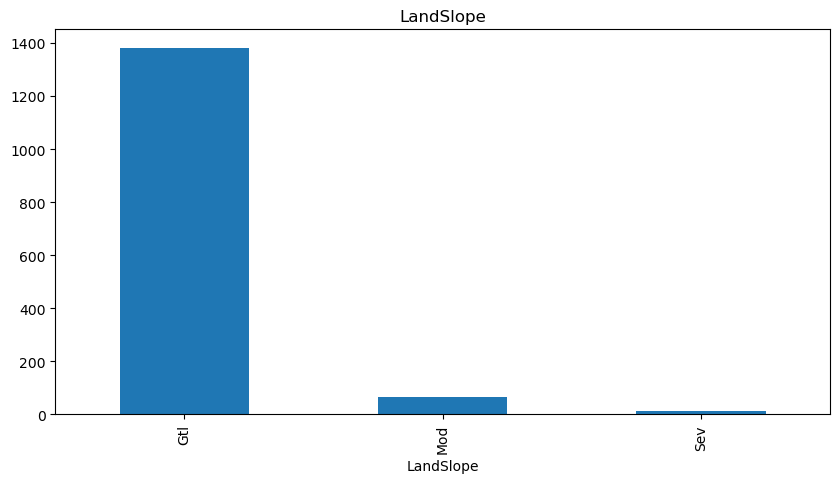

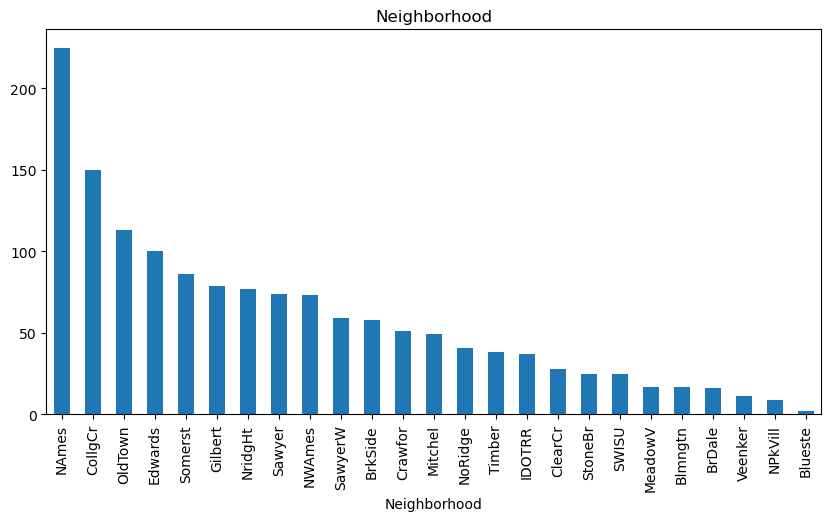

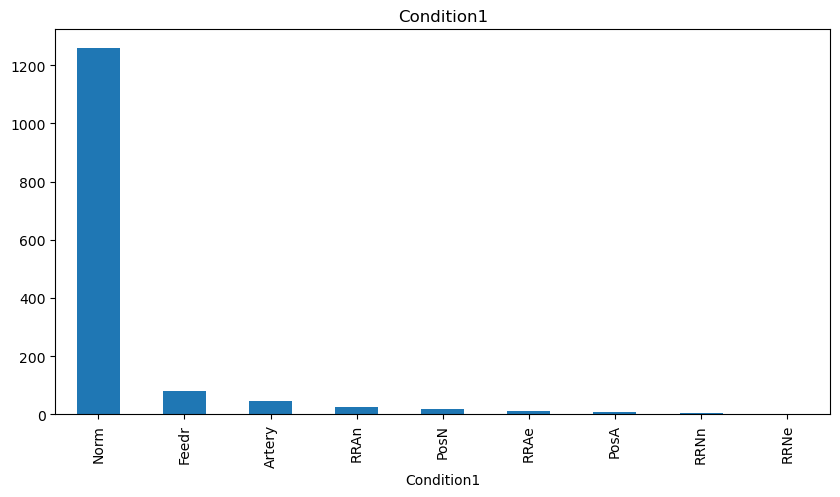

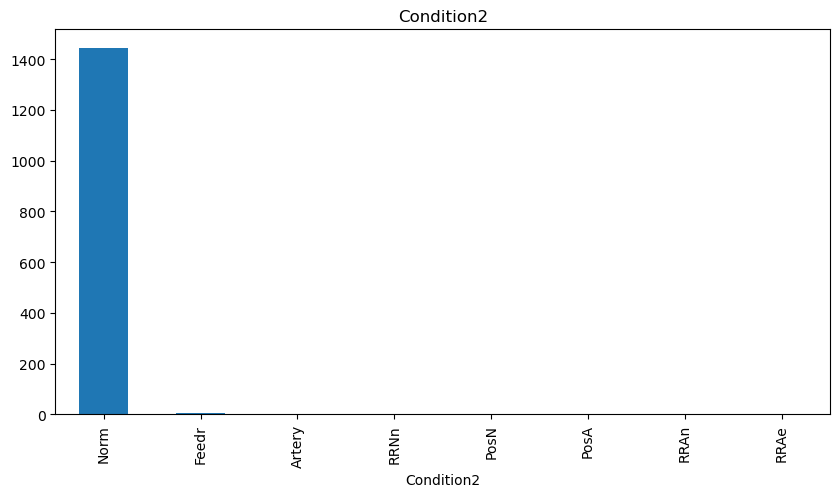

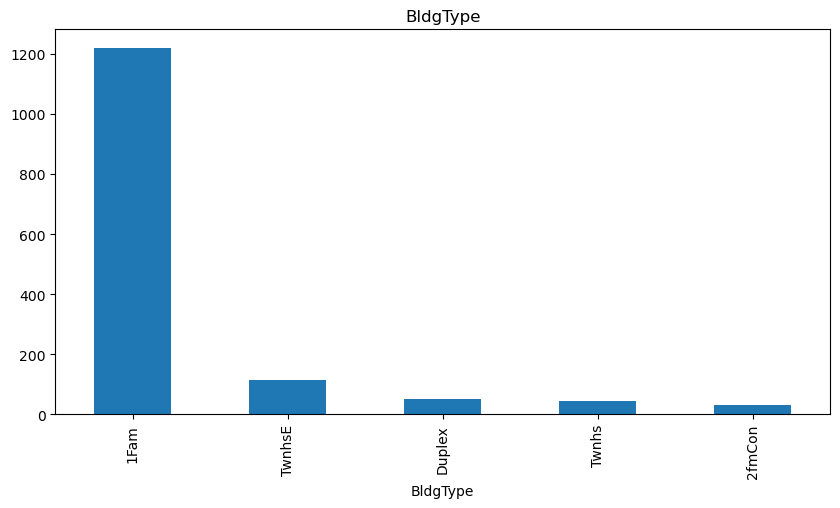

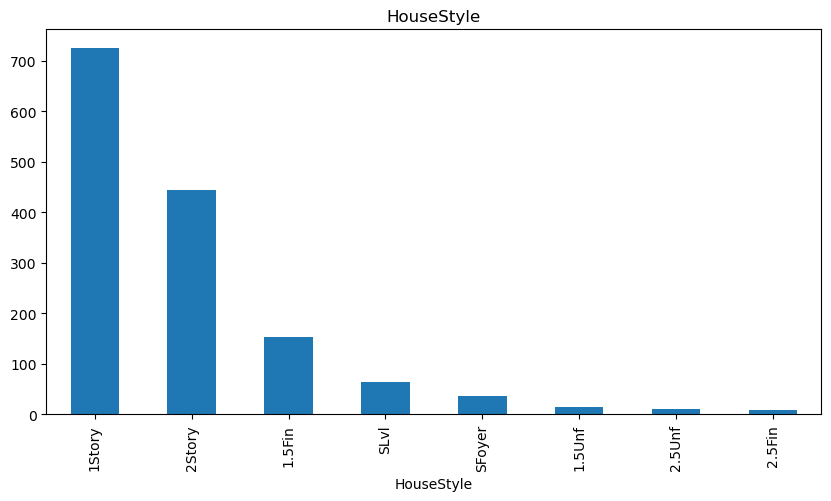

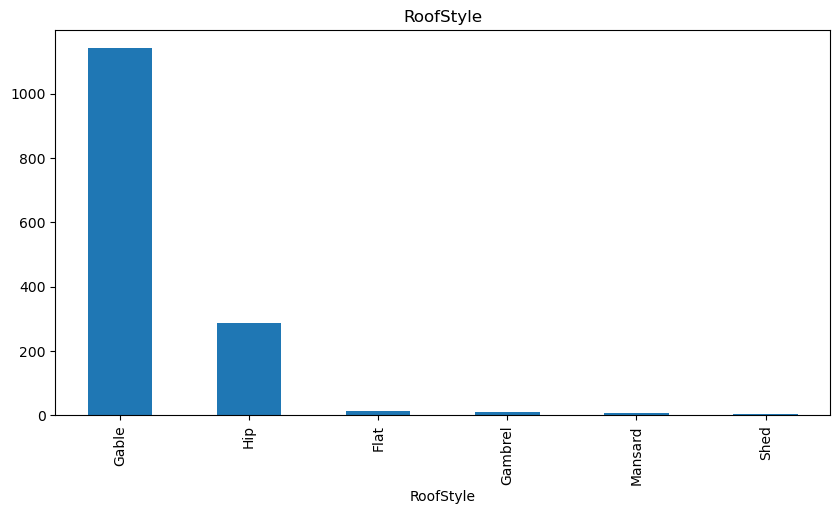

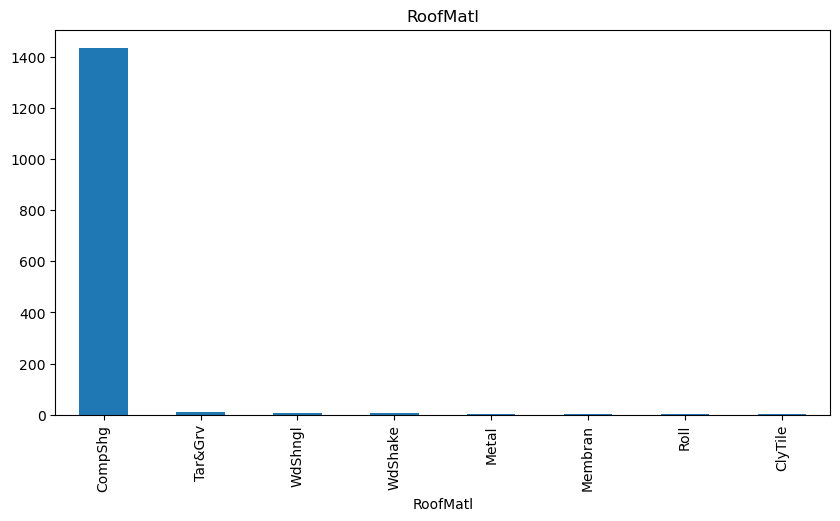

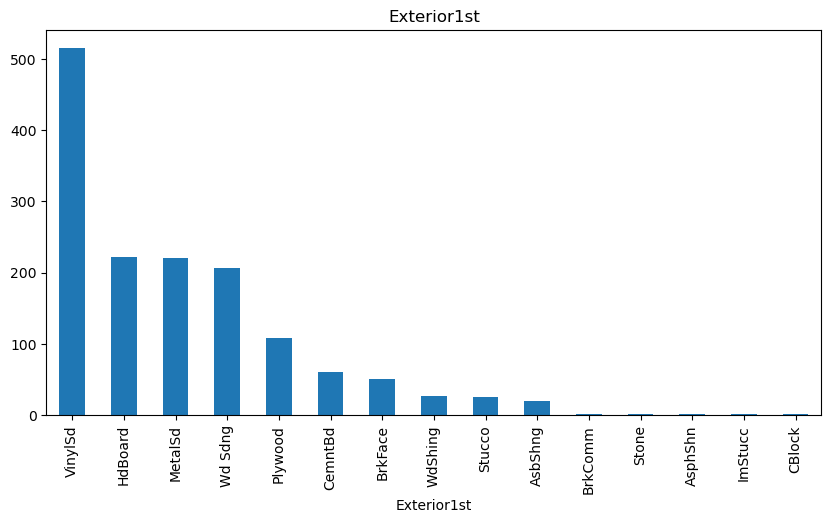

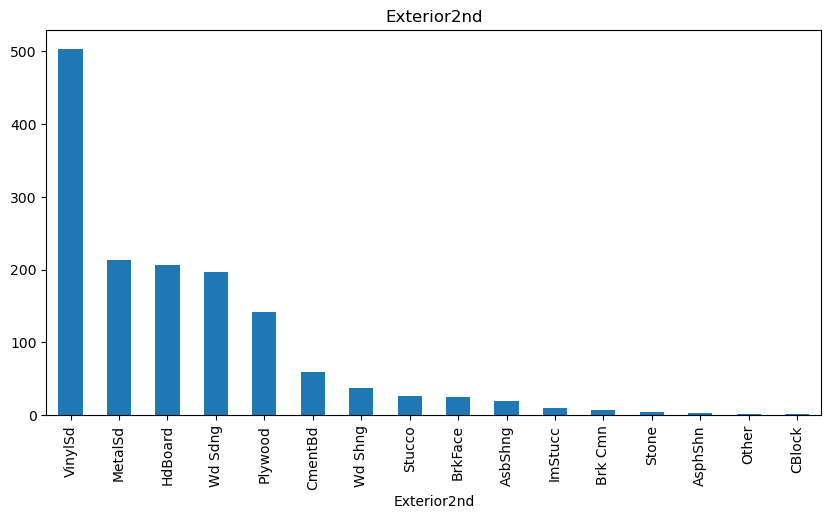

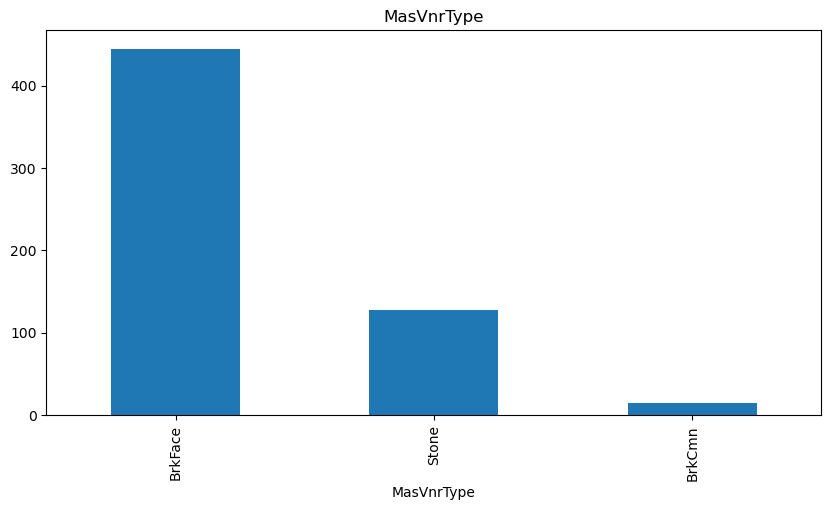

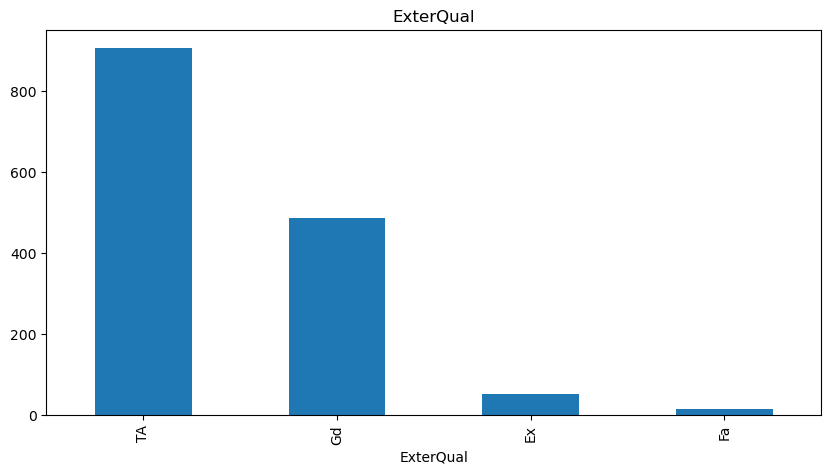

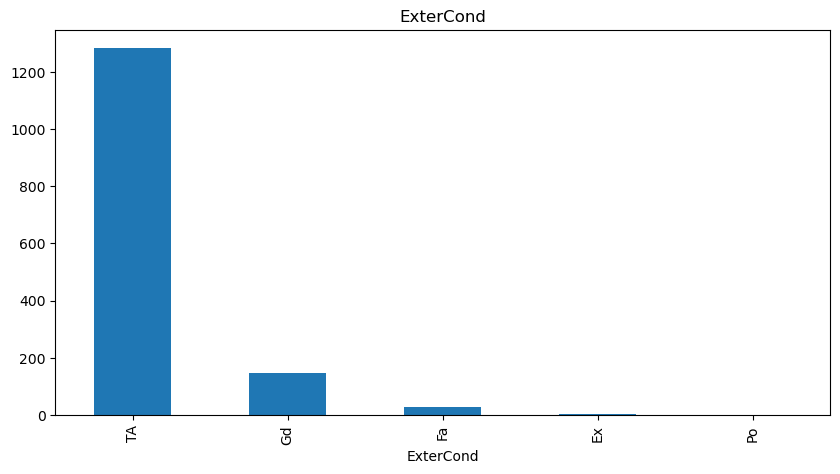

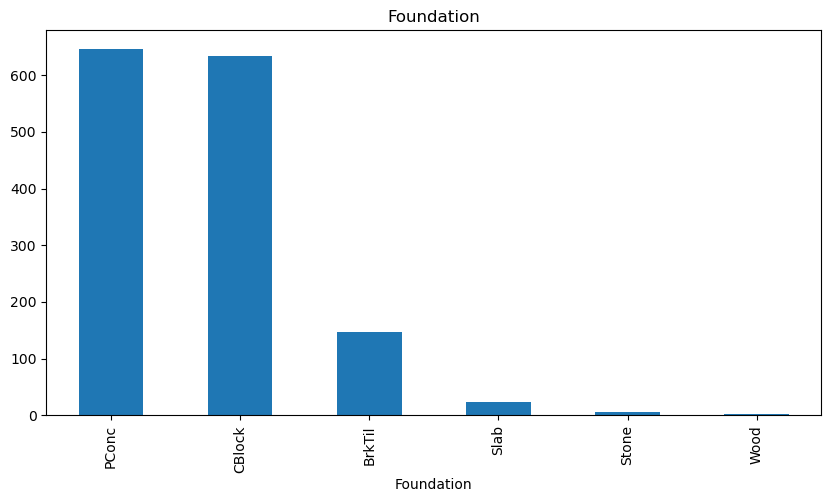

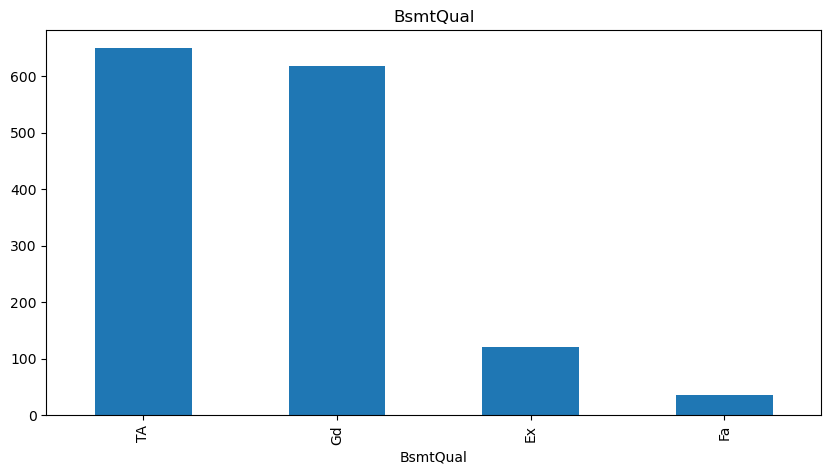

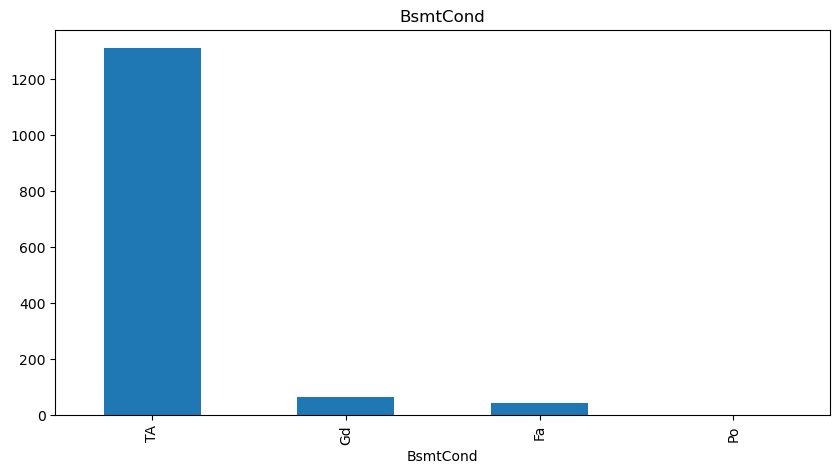

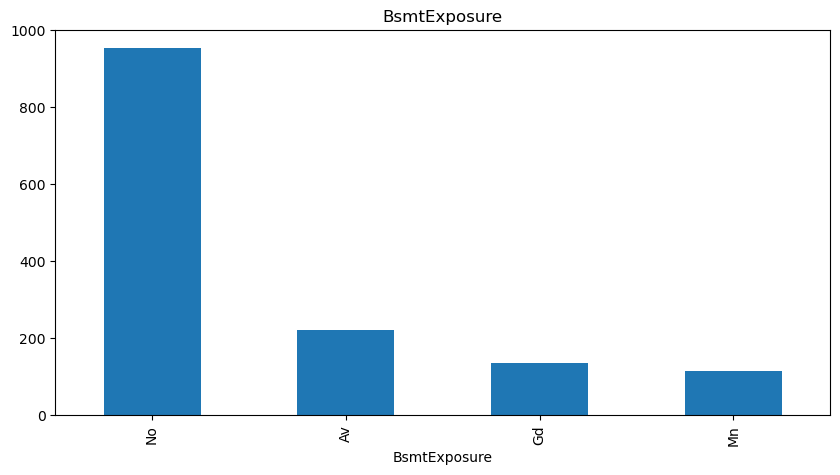

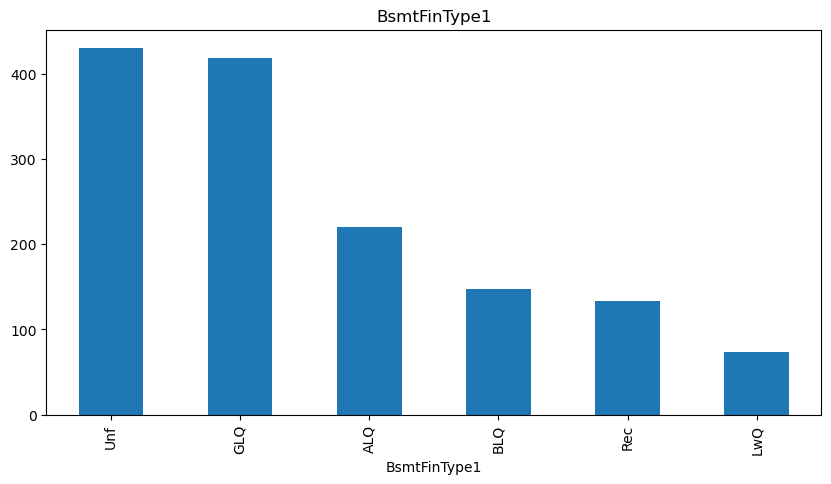

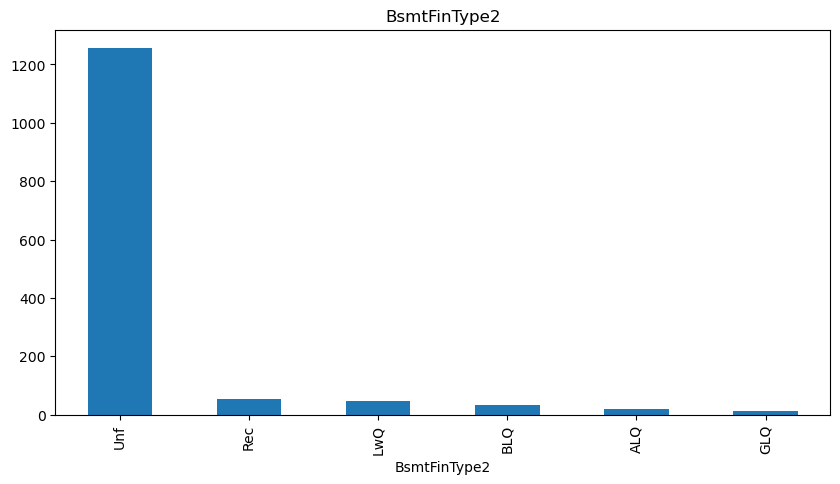

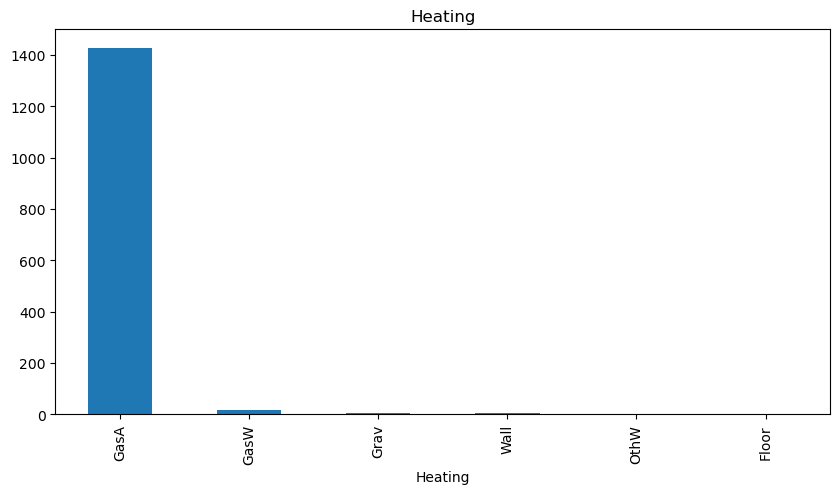

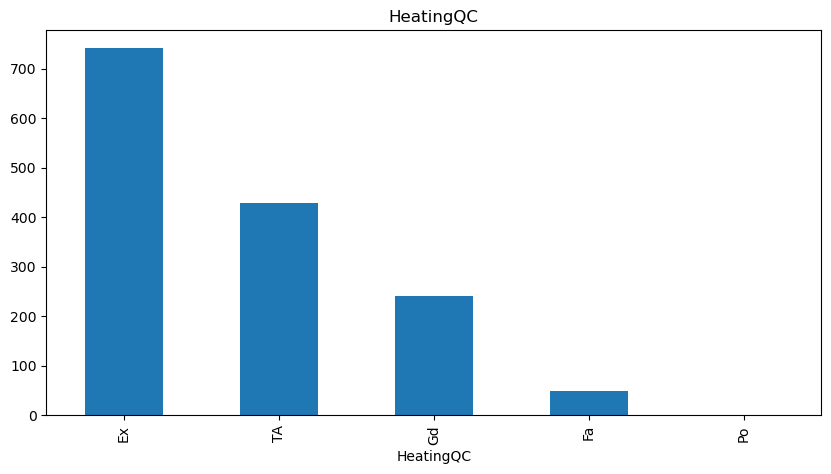

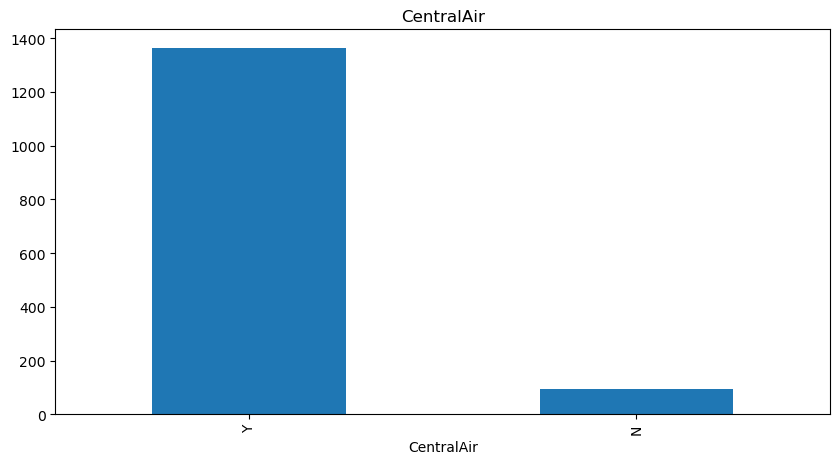

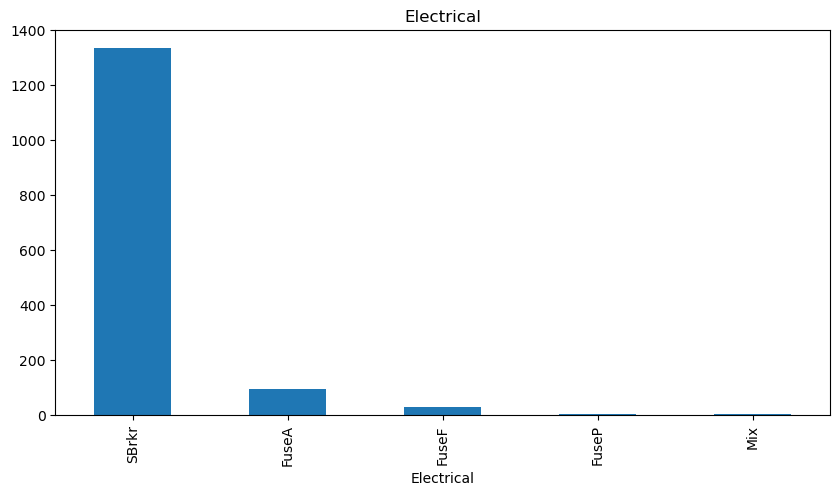

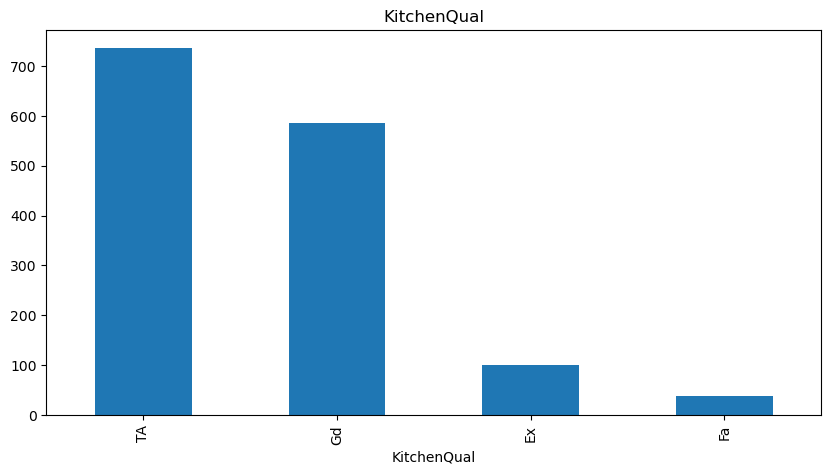

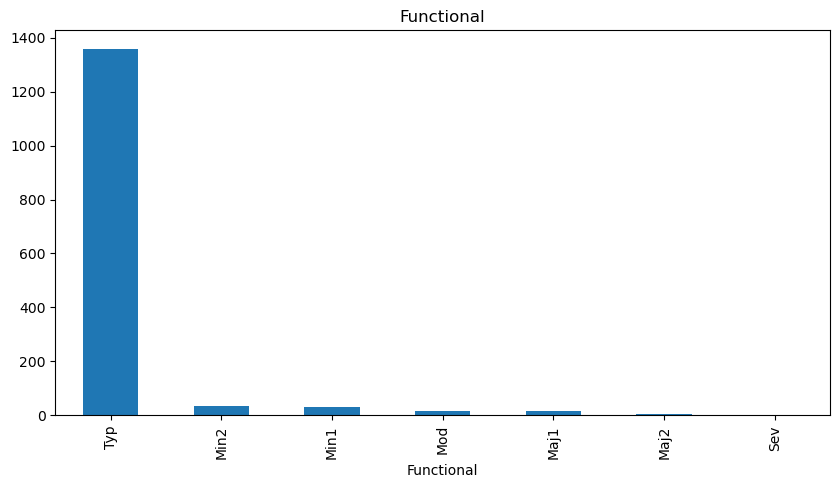

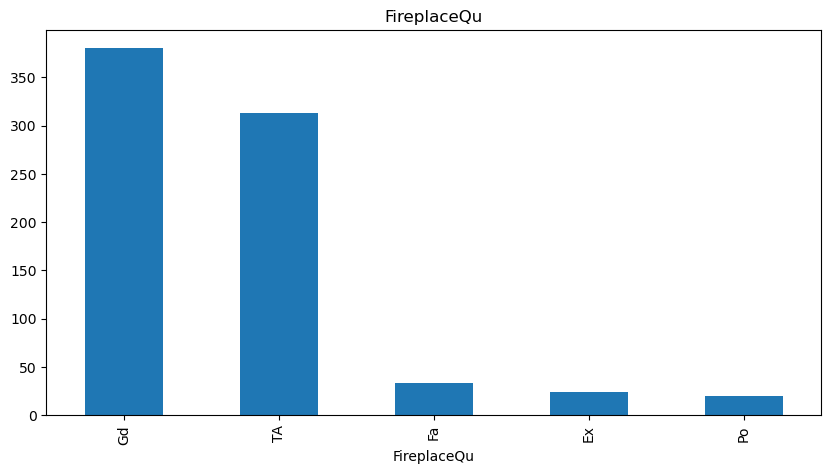

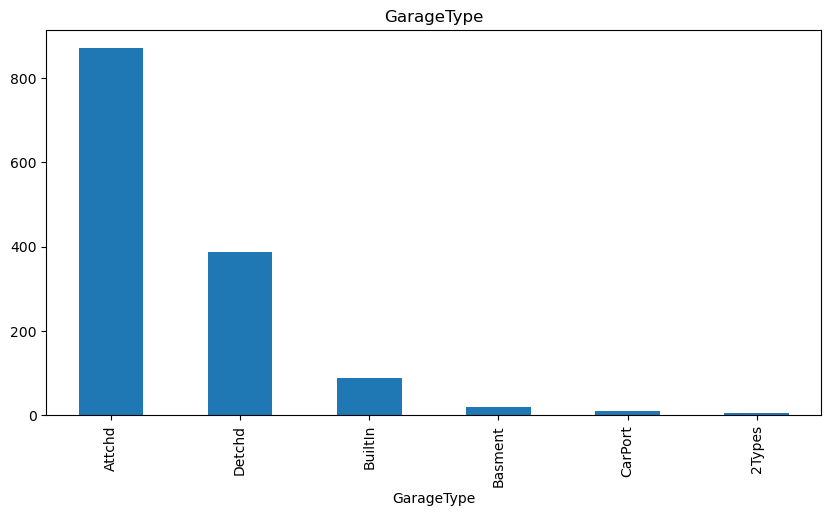

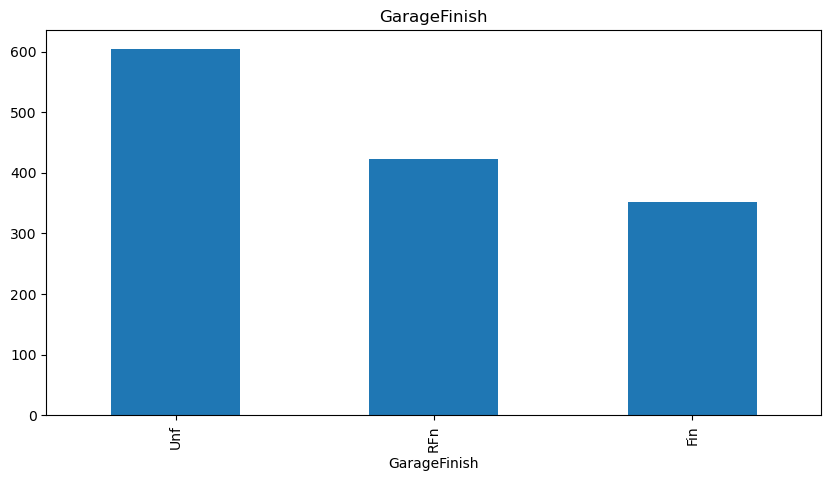

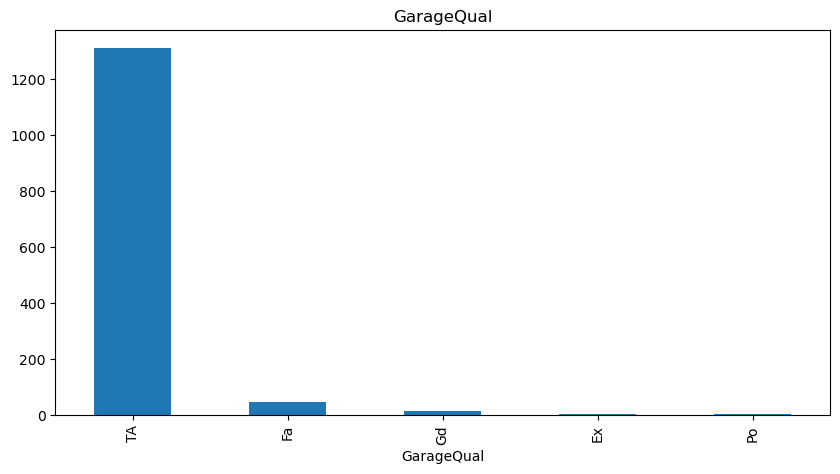

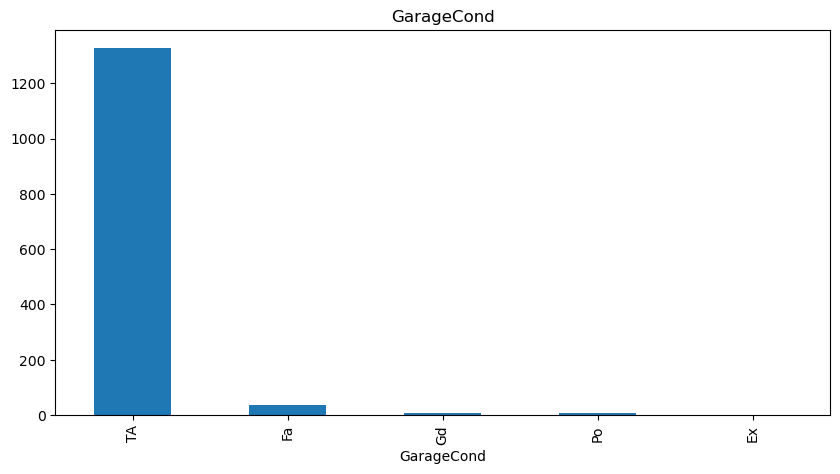

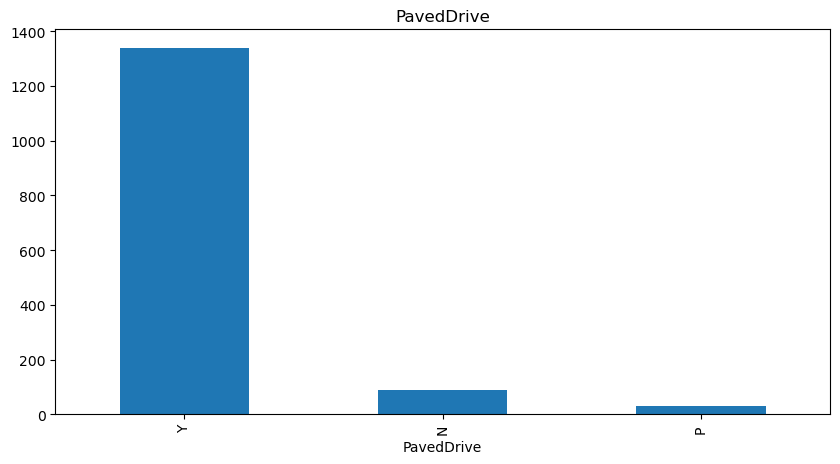

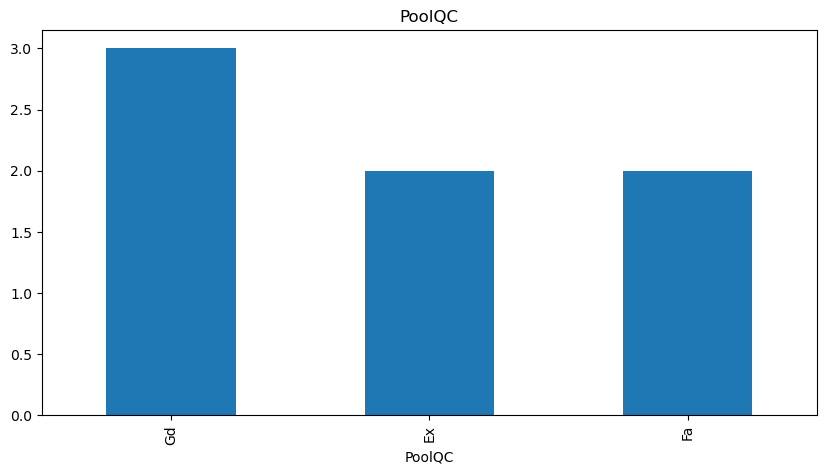

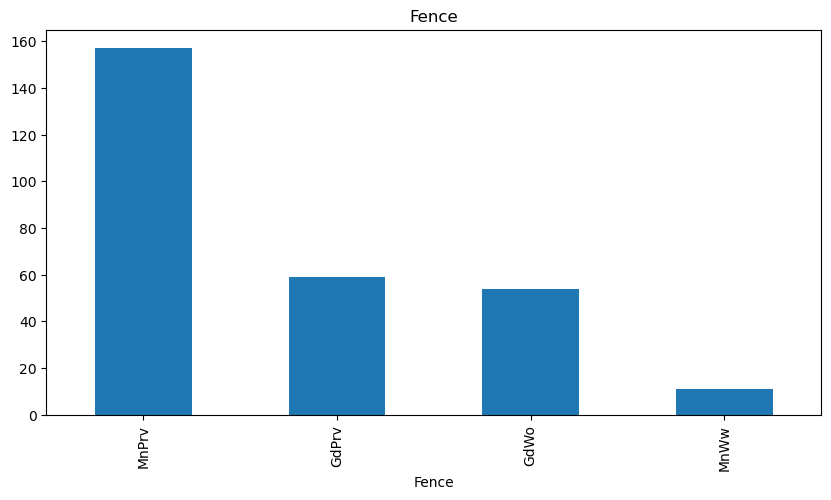

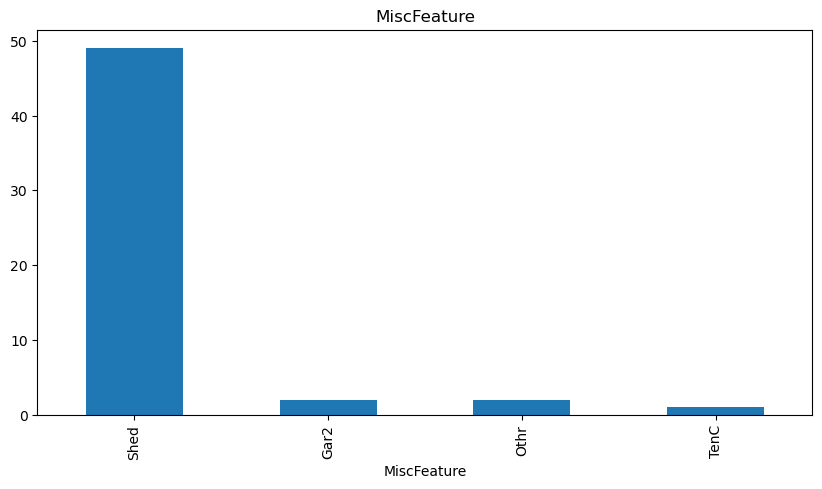

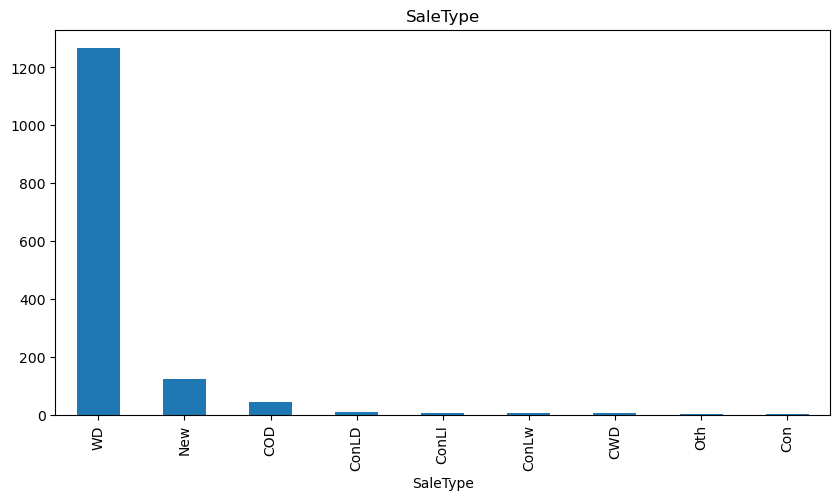

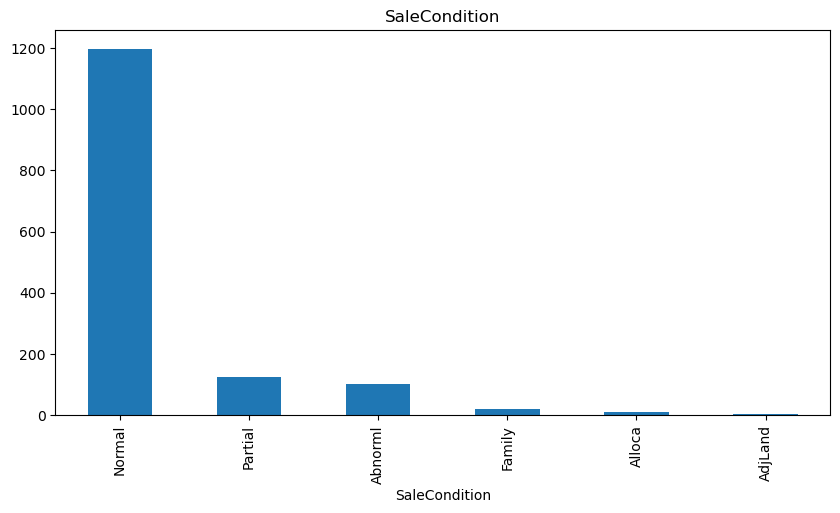

In [174]:
# Visualizações para variáveis categóricas para entender a frequência dos diferentes valores. (att_13:14_16)
cat_features = data.select_dtypes(include=[object]).columns
for col in cat_features:
    plt.figure(figsize=(10, 5))
    data[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.show()

In [175]:
# Uma análise de outliers nas variáveis numéricas. (att_13:16_16)
from scipy import stats
z_scores = stats.zscore(numerical_data)
outliers = (np.abs(z_scores) > 3).sum(axis=0)
print("Outliers por variável:\n", outliers)


Outliers por variável:
 Id                0
MSSubClass       30
LotFrontage       0
LotArea          13
OverallQual       2
OverallCond      28
YearBuilt         6
YearRemodAdd      0
MasVnrArea        0
BsmtFinSF1        6
BsmtFinSF2       50
BsmtUnfSF        11
TotalBsmtSF      10
1stFlrSF         12
2ndFlrSF          4
LowQualFinSF     20
GrLivArea        16
BsmtFullBath     16
BsmtHalfBath     82
FullBath          0
HalfBath         12
BedroomAbvGr     14
KitchenAbvGr     68
TotRmsAbvGrd     12
Fireplaces        5
GarageYrBlt       0
GarageCars        0
GarageArea        7
WoodDeckSF       22
OpenPorchSF      27
EnclosedPorch    51
3SsnPorch        23
ScreenPorch      55
PoolArea          7
MiscVal           8
MoSold            0
YrSold            0
SalePrice        22
dtype: int64


In [176]:
# Verificação de valores faltantes
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("Valores faltantes:\n", missing_values)


Valores faltantes:
 LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


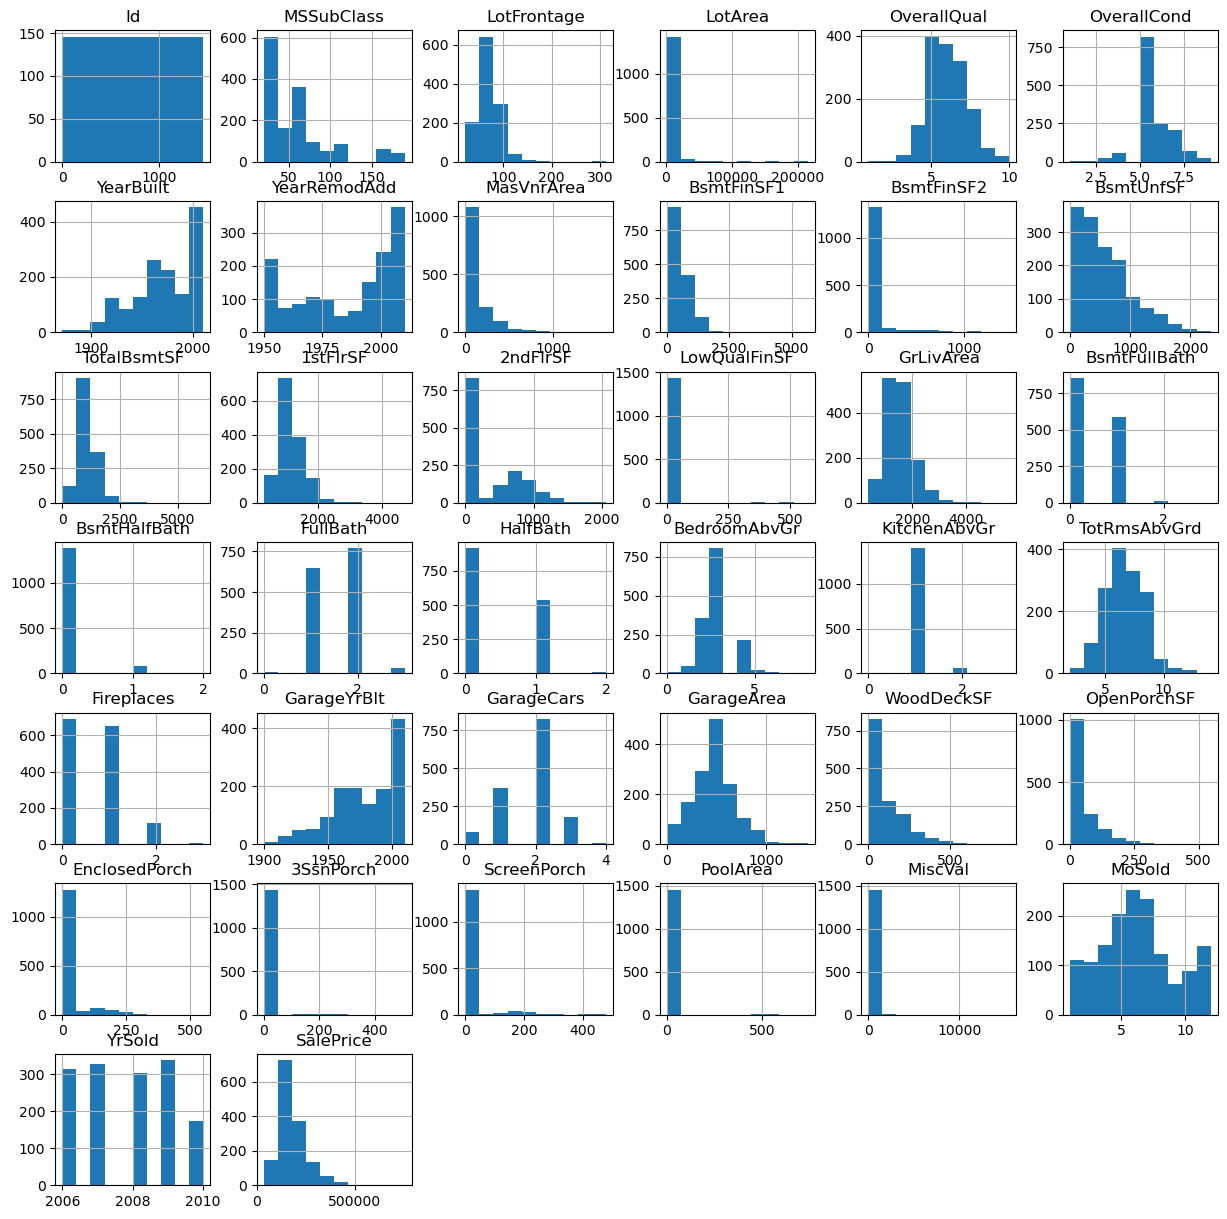

In [177]:
# Visualização da distribuição das variáveis numéricas
num_features = data.select_dtypes(include=[np.number]).columns
data[num_features].hist(figsize=(15, 15))
plt.show()


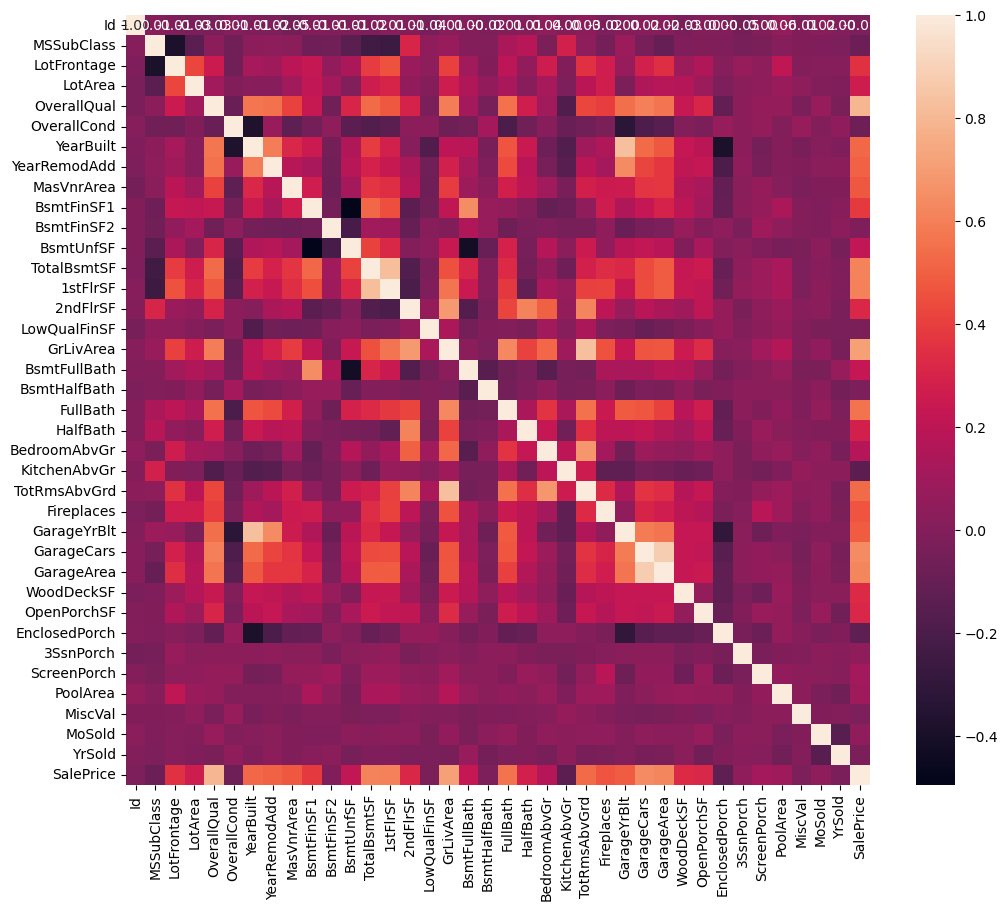

In [178]:
# Matriz de correlação (excluindo variáveis não numéricas)
numerical_data = data.select_dtypes(include=[np.number])
correlation_matrix = numerical_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.show()

In [179]:
# 2. Feature Engineering

In [180]:
# Preenchendo valores faltantes para variáveis numéricas com a média
data[num_features] = data[num_features].fillna(data[num_features].mean())


In [181]:
# Preenchendo valores faltantes para variáveis categóricas com 'Missing'
categorical_features = data.select_dtypes(include=[object]).columns
data[categorical_features] = data[categorical_features].fillna('Missing')

In [182]:
# Codificação de variáveis categóricas
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

In [183]:
# Normalização dos dados
scaler = StandardScaler()
data[num_features] = scaler.fit_transform(data[num_features])

In [184]:
# Transformação de variáveis skewed com PowerTransformer
skewed_features = data[num_features].apply(lambda x: x.skew()).sort_values(ascending=False)
skewed_features = skewed_features[skewed_features > 0.75]

In [185]:
pt = PowerTransformer(method='yeo-johnson')
data[skewed_features.index] = pt.fit_transform(data[skewed_features.index])

In [186]:
# Criação de novas features (exemplo: interação entre variáveis)
data['OverallQual_GrLivArea'] = data['OverallQual'] * data['GrLivArea']
data['OverallQual_TotalBsmtSF'] = data['OverallQual'] * data['TotalBsmtSF']

In [187]:
# Separar features e target
X = data.drop("SalePrice", axis=1)
y = data["SalePrice"]

In [188]:
# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [189]:
# Normalização dos dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [190]:
#Análise de Importância de Características: (att:_14:51_16)
#Para modelos como Random Forest ou XGBoost, você pode extrair a importância das características e selecionar as mais importantes.
corr_matrix = data.corr()
corr_target = abs(corr_matrix['SalePrice'])
relevant_features = corr_target[corr_target > 0.5].index.tolist()
X = data[relevant_features]


In [192]:
# 3. Aprendizagem Supervisionada
# a. Regressão Linear


In [193]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Regressão Linear - RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("Regressão Linear - R2 Score:", r2_score(y_test, y_pred_lr))


Regressão Linear - RMSE: 1535057838.1697562
Regressão Linear - R2 Score: -2.0558839629087503e+18


In [194]:
# b. Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest - RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest - R2 Score:", r2_score(y_test, y_pred_rf))

Random Forest - RMSE: 0.3577168525119885
Random Forest - R2 Score: 0.8883579215093544


In [195]:
# aqui

In [196]:
# Definir um threshold para classificar o preço de venda como alto ou baixo
threshold = data['SalePrice'].median()

In [197]:
# Criar a variável binária 'SalePrice_bin' (1 para alto, 0 para baixo)
data['SalePrice_bin'] = (data['SalePrice'] > threshold).astype(int)

In [198]:
# Separar features e target para classificação
X_classification = data.drop(["SalePrice", "SalePrice_bin"], axis=1)  # Excluir as colunas de preço original e binário
y_classification = data["SalePrice_bin"]

In [199]:
# Dividir em treino e teste
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)


In [200]:
# Normalização dos dados para classificação (se necessário)
scaler_clf = StandardScaler()
X_train_clf = scaler_clf.fit_transform(X_train_clf)
X_test_clf = scaler_clf.transform(X_test_clf)

In [201]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42)
clf.fit(X_train_clf, y_train_clf)
y_pred_clf = clf.predict(X_test_clf)

In [202]:
# Avaliação do modelo de classificação
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Modelo de Classificação - Acurácia:", accuracy_score(y_test_clf, y_pred_clf))
print("Matriz de Confusão:\n", confusion_matrix(y_test_clf, y_pred_clf))
print("Relatório de Classificação:\n", classification_report(y_test_clf, y_pred_clf))

Modelo de Classificação - Acurácia: 0.9452054794520548
Matriz de Confusão:
 [[150  11]
 [  5 126]]
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95       161
           1       0.92      0.96      0.94       131

    accuracy                           0.95       292
   macro avg       0.94      0.95      0.94       292
weighted avg       0.95      0.95      0.95       292



In [203]:
#aqui

In [204]:
# 4. Aprendizagem Não Supervisionada
# a. Clusterização (KMeans)

C:\Users\jppec\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


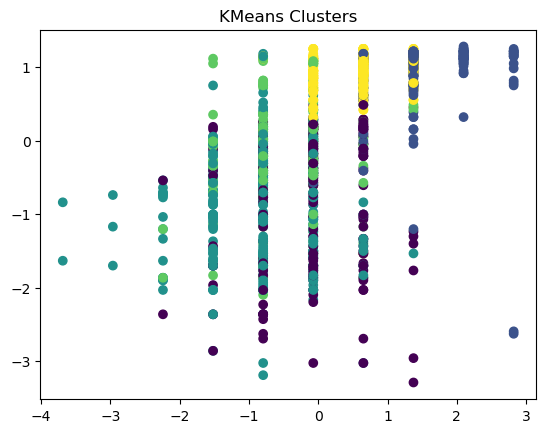

In [205]:
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)  # Definindo explicitamente o valor de n_init
clusters = kmeans.fit_predict(X)
X_np = X.values
plt.scatter(X_np[:, 0], X_np[:, 1], c=clusters)
plt.title("KMeans Clusters")
plt.show()

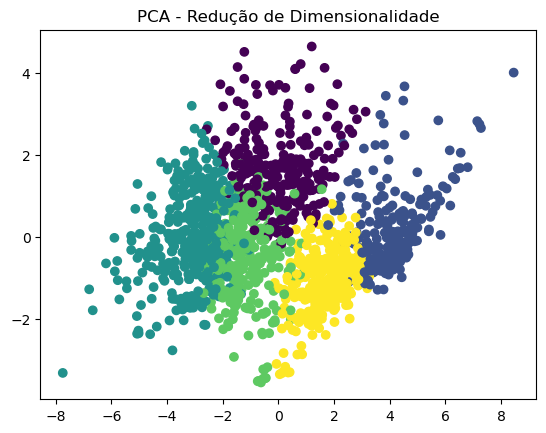

In [206]:
# b. Redução de dimensionalidade (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters)
plt.title("PCA - Redução de Dimensionalidade")
plt.show()

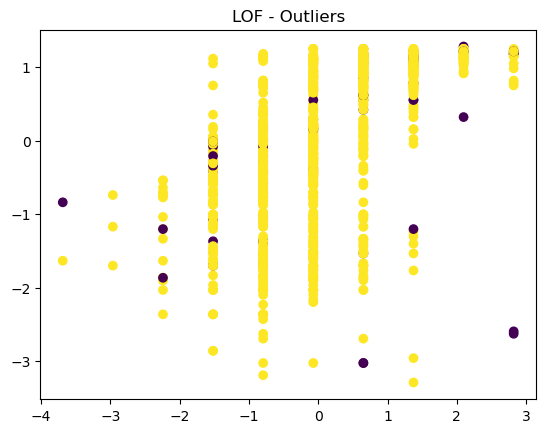

In [207]:
# c. Análise de outlier (LOF)
lof = LocalOutlierFactor(n_neighbors=20)
outliers = lof.fit_predict(X)
plt.scatter(X_np[:, 0], X_np[:, 1], c=outliers)
plt.title("LOF - Outliers")
plt.show()

In [208]:
from sklearn.neighbors import LocalOutlierFactor


In [209]:
# Criar o modelo LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
outliers = lof.fit_predict(X)


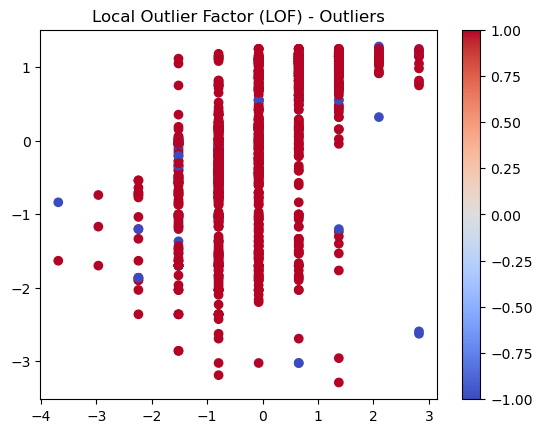

In [210]:
# Visualizar os outliers
plt.scatter(X_np[:, 0], X_np[:, 1], c=outliers, cmap='coolwarm')
plt.title("Local Outlier Factor (LOF) - Outliers")
plt.colorbar()
plt.show()

In [211]:
from sklearn.metrics import silhouette_score


In [212]:
# Calcular o silhouette score para os clusters gerados pelo KMeans
silhouette_avg = silhouette_score(X, clusters)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.1774134431099252
